In [1]:
!pip install kaggle

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d kwentar/blur-dataset

 99% 1.48G/1.49G [00:15<00:00, 172MB/s]
100% 1.49G/1.49G [00:17<00:00, 90.9MB/s]


In [4]:
!unzip -q blur-dataset.zip -d ./blur-dataset

In [14]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from skimage.filters import laplace, sobel, roberts
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
s_path ='./blur-dataset/blur_dataset_scaled/sharp/'
df_path='./blur-dataset/blur_dataset_scaled/defocused_blurred/'
mot_path ='./blur-dataset/blur_dataset_scaled/motion_blurred/'

In [15]:
# Load and preprocess images and labels
sharp_images = os.listdir(s_path)
defocused_images = os.listdir(df_path)
motion_blurred_images = os.listdir(mot_path)

def get_data(path, images):
    features = []
    for img in images:
        image_gray = cv2.imread(path + img, 0)
        lap_feat = laplace(image_gray)
        sob_feat = sobel(image_gray)
        rob_feat = roberts(image_gray)
        feature = [lap_feat.mean(), lap_feat.var(), np.amax(lap_feat),
                   sob_feat.mean(), sob_feat.var(), np.max(sob_feat),
                   rob_feat.mean(), rob_feat.var(), np.max(rob_feat)]
        features.append(feature)
    return features

sharp_features = get_data(s_path, sharp_images)
defocused_features = get_data(df_path, defocused_images)
motion_blur_features = get_data(mot_path, motion_blurred_images)

X = np.vstack((sharp_features, defocused_features, motion_blur_features))
y = np.concatenate((np.zeros(len(sharp_features)),
                    np.ones(len(defocused_features)),
                    np.ones(len(motion_blur_features)) * 2))

y_categorical = to_categorical(y, num_classes=3)

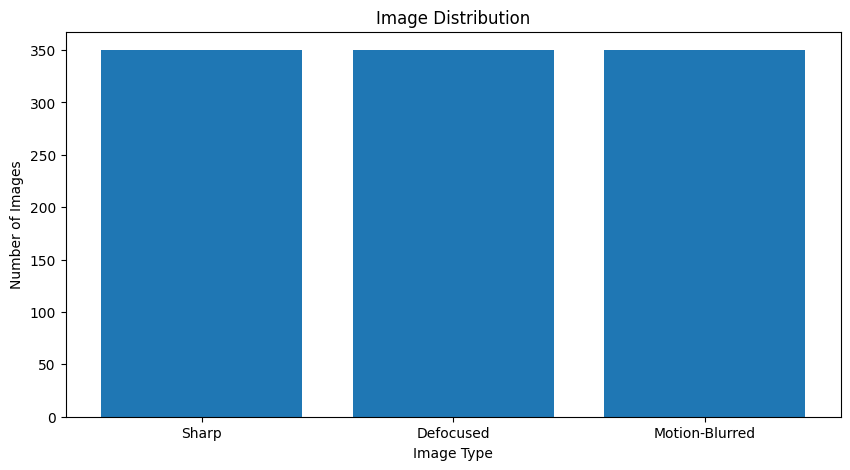

In [16]:
# EDA: Image Distribution
plt.figure(figsize=(10, 5))
plt.bar(['Sharp', 'Defocused', 'Motion-Blurred'], [len(sharp_features), len(defocused_features), len(motion_blur_features)])
plt.xlabel('Image Type')
plt.ylabel('Number of Images')
plt.title('Image Distribution')
plt.show()

In [17]:
# EDA: Visualize Sample Images
def show_sample_images(image_paths, title):
    plt.figure(figsize=(12, 6))
    for i, img_path in enumerate(image_paths[:6]):
        img = cv2.imread(img_path)
        plt.subplot(2, 3, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

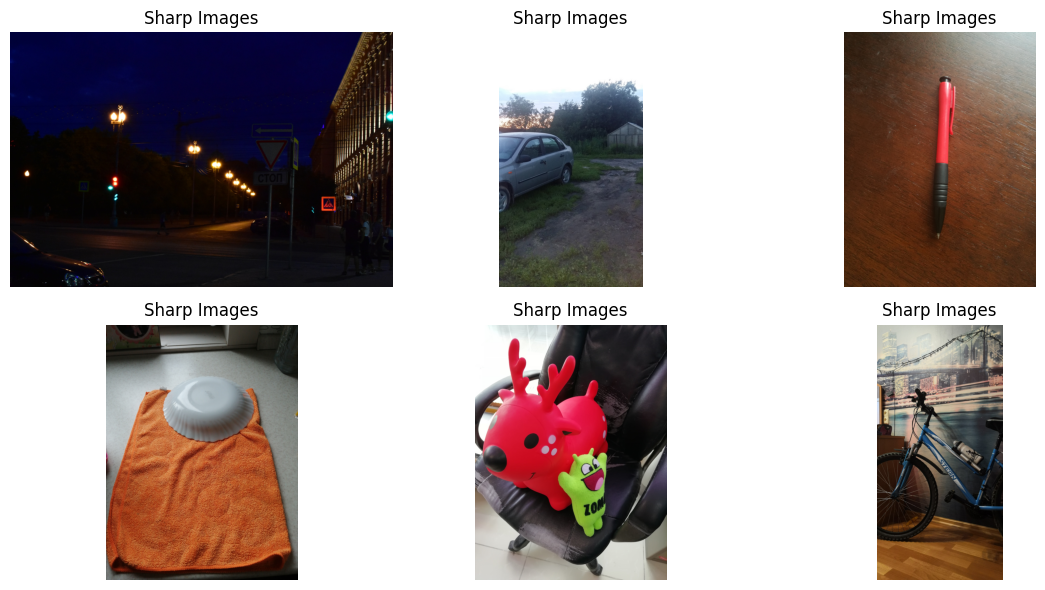

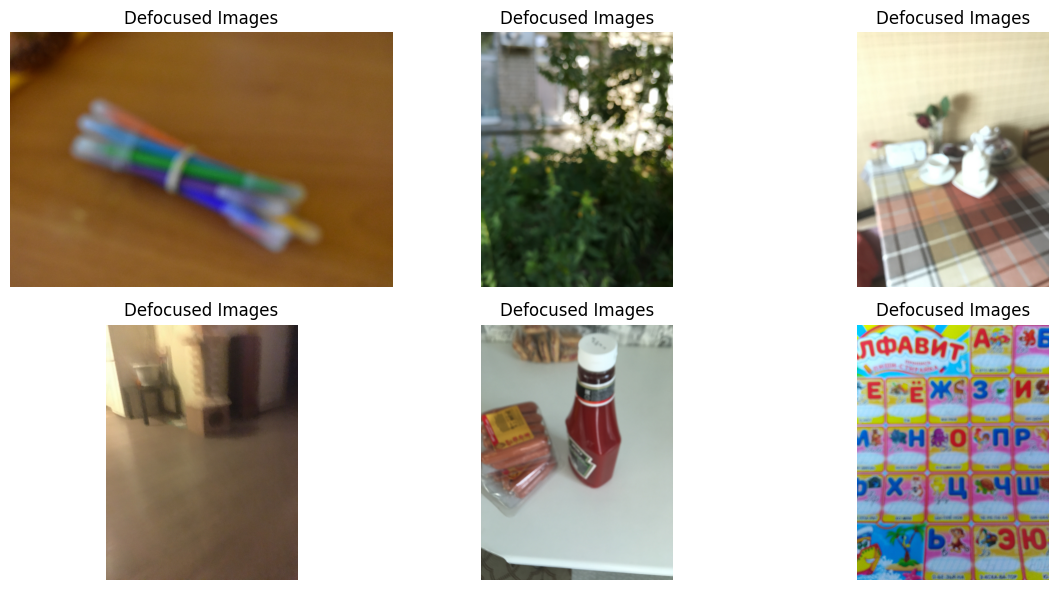

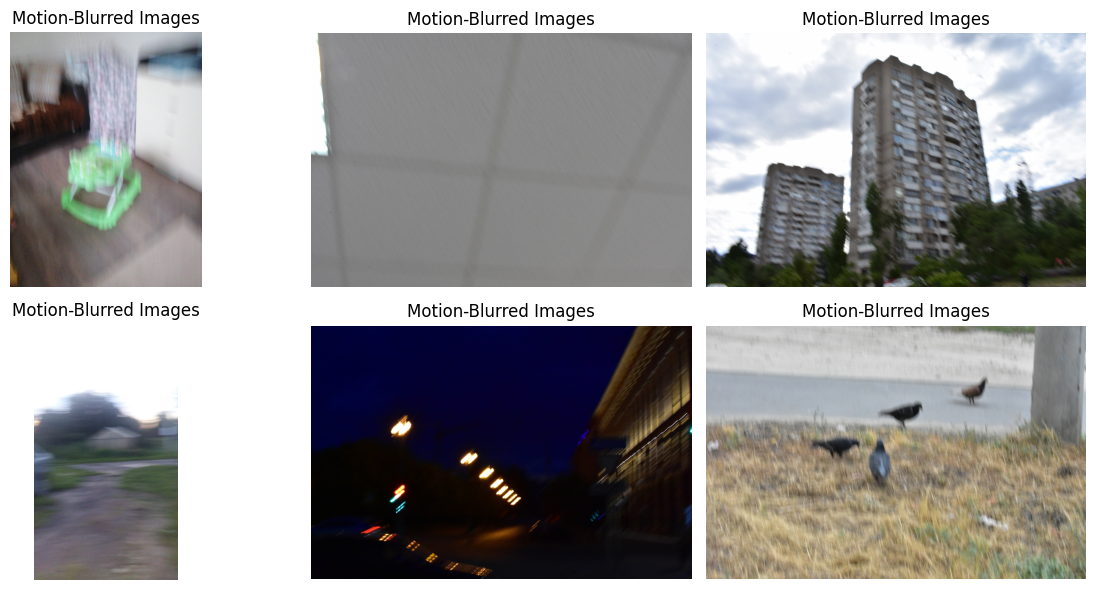

In [18]:
show_sample_images([s_path + img for img in sharp_images], 'Sharp Images')
show_sample_images([df_path + img for img in defocused_images], 'Defocused Images')
show_sample_images([mot_path + img for img in motion_blurred_images], 'Motion-Blurred Images')

# EDA: Visualize Edge Detection
def visualize_edge_detection(image_paths, title):
    plt.figure(figsize=(12, 6))
    for i, img_path in enumerate(image_paths[:6]):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        lap_feat = laplace(img)
        sob_feat = sobel(img)
        rob_feat = roberts(img)
        plt.subplot(2, 3, i + 1)
        plt.imshow(lap_feat, cmap='gray')
        plt.title(f'{title} - Laplace')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

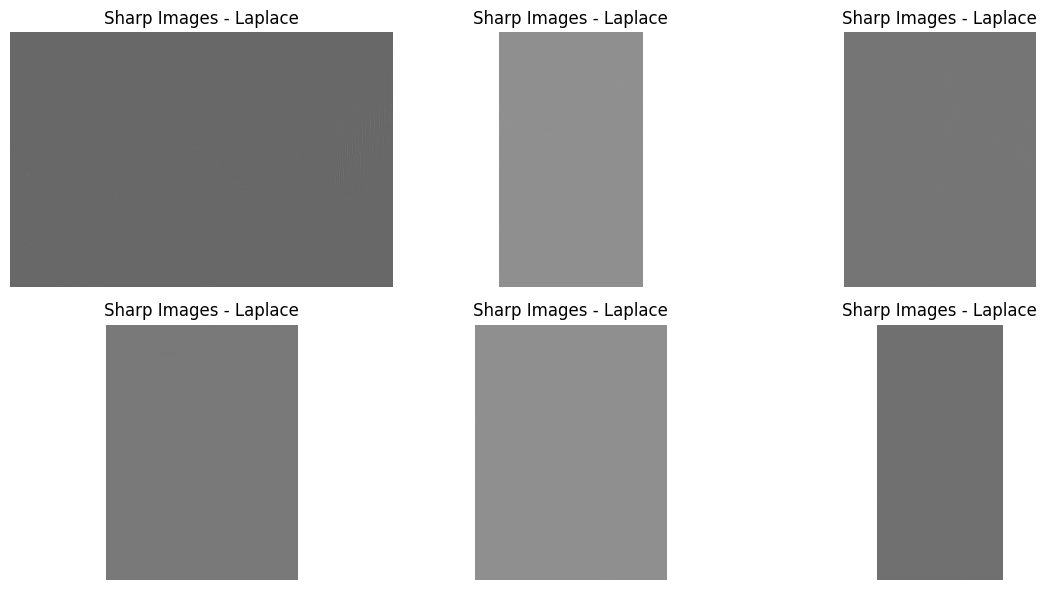

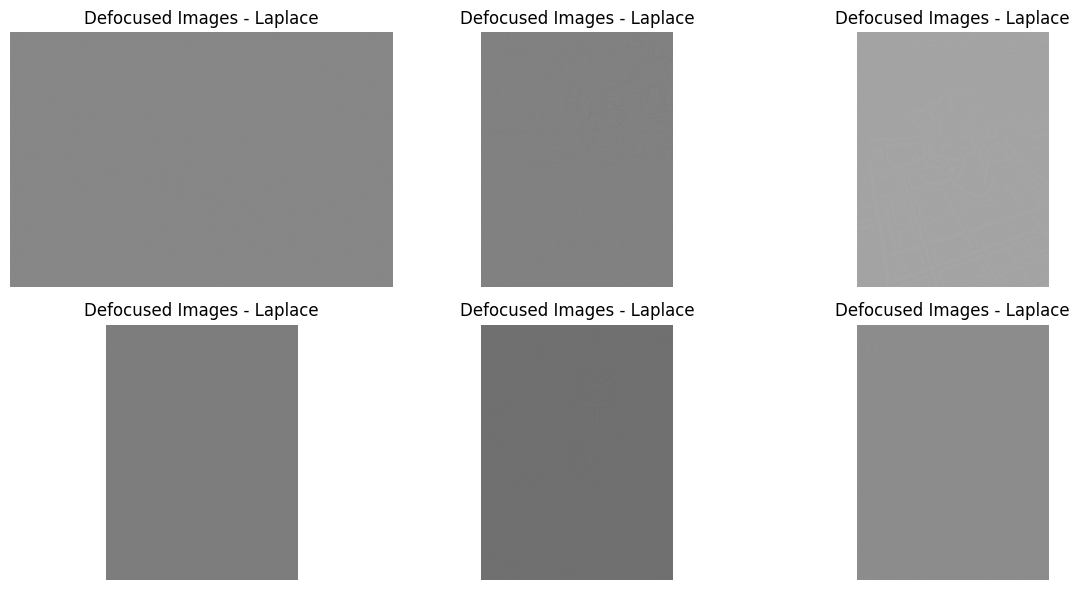

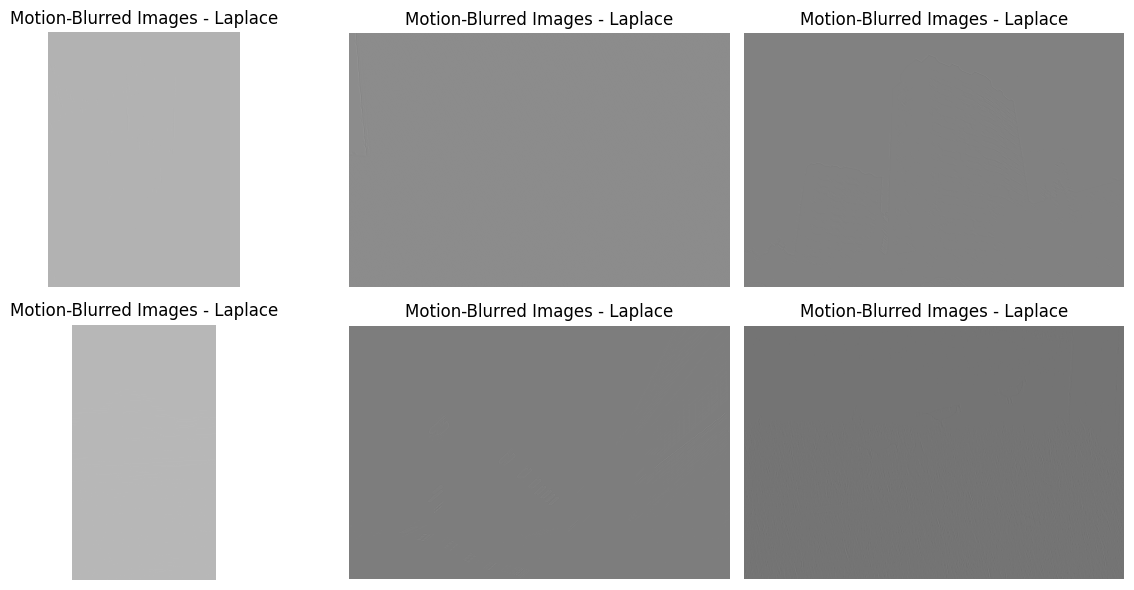

In [21]:
visualize_edge_detection([s_path + img for img in sharp_images], 'Sharp Images')
visualize_edge_detection([df_path + img for img in defocused_images], 'Defocused Images')
visualize_edge_detection([mot_path + img for img in motion_blurred_images], 'Motion-Blurred Images')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               1280      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                                 
Total params: 9,731
Trainable params: 9,731
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
22/22 [==============================] - 

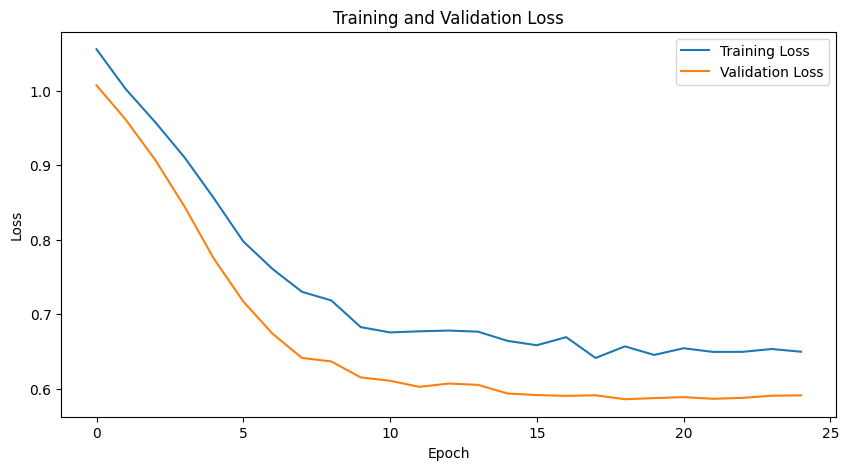

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_categorical, test_size=0.33, stratify=y_categorical)

# Create a CNN model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(9,)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_valid, y_valid))

# EDA: Visualize Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

11/11 [==============================] - 0s 1ms/step


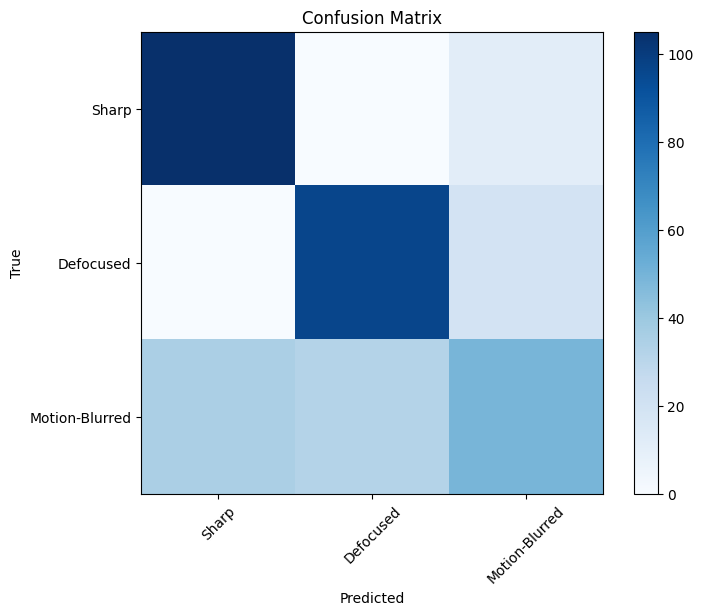

In [24]:
# EDA: Visualize Model Performance
pred = model.predict(X_valid)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_valid, axis=1)

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(['Sharp', 'Defocused', 'Motion-Blurred']))
plt.xticks(tick_marks, ['Sharp', 'Defocused', 'Motion-Blurred'], rotation=45)
plt.yticks(tick_marks, ['Sharp', 'Defocused', 'Motion-Blurred'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
print('Classification report:\n', classification_report(y_true, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.75      0.91      0.82       116
           1       0.75      0.83      0.79       115
           2       0.62      0.42      0.50       116

    accuracy                           0.72       347
   macro avg       0.71      0.72      0.70       347
weighted avg       0.71      0.72      0.70       347

